<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Actor-Critic/A3C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
pip install torch==1.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 1.11.0 which is incompatible.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
from itertools import count
import torch.multiprocessing as mp

In [3]:
torch.__version__

'1.11.0+cu102'

# Policy Network as Actor

This is the fully connected policy network we will use as actor in the A3C algorithm:

In [11]:
class PolicyNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):

    super(PolicyNetwork, self).__init__()

    # set the activation fct for the fully connected layer
    self.activation_fc = activation_fc

    # the input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    # the hidden layers
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # the output layer
    self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)

    return x

  def forward(self, state):
    '''
    Define the forward pass.
    '''
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))

    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    return self.output_layer(x)

  def full_pass(self, state):
    # perform the forward pass to obtain the logits (preferences over the actions)
    # logits are interpreted to be the unnormalized (or not yet normalized) predictions
    # (or outputs) of a model
    logits = self.forward(state)

    # create a probability distribution using the logits
    dist = torch.distributions.Categorical(logits=logits)

    # sample an action from the probability distribution
    action = dist.sample()

    # get the log probabilities of the selected action
    logpa = dist.log_prob(action).unsqueeze(-1)

    # compute the entropy of the policy
    # high entropy when action probabilities are similar to each other
    # low entropy when 1 action has a very high probability & all other actions have low probability
    # the entropy will be used in the loss function
    entropy = dist.entropy().unsqueeze(-1)

    # return the selected action and its log probability
    return action.item(), logpa, entropy


  def select_action(self, state):
    '''
    Sample an action from the probability distribution.
    '''
    logits = self.forward(state)
    dist = torch.distributions.Categorical(logits=logits)
    action = dist.sample()
    return action.item()

  def select_greedy_action(self, state):
    '''
    Select a greedy action according to the policy.
    '''
    logits = self.forward(state)
    return np.argmax(logits.detach().numpy())

# Value Network as Critic

This is the fully connected value network we will use as critic in the A3C algorithm:

In [12]:
class ValueNetwork(nn.Module):
  def __init__(self,
               input_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):

    super(ValueNetwork, self).__init__()

    # set the activation fct for the activation layer
    self.activation_fc = activation_fc

    # the input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    # the hidden layer(s)
    self.hidden_layers = nn.ModuleList()

    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # the output layer
    # (only 1 output since the outcome of a state-value fct is a single value)
    self.output_layer = nn.Linear(hidden_dims[-1], 1)


  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, dtype=torch.float32)
      x = x.unsqueeze(0)

    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))

    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    return self.output_layer(x)

# Shared Optimizer

To implement asynchronous model updates, we need a shared optimizer. This the shared optimizer we are going to use for the policy network:

In [13]:
class SharedAdam(torch.optim.Adam):

  def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False):
    super(SharedAdam, self).__init__(params, lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, amsgrad=amsgrad)
    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0
        state['shared_step'] = torch.zeros(1).share_memory_()
        state['exp_avg'] = torch.zeros_like(p.data).share_memory_()
        state['exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()
        if weight_decay:
          state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
        if amsgrad:
          state['max_exp_avg_sq'] = torch.zeros_like(p.data).share_memory_()

  def step(self, closure=None):
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        self.state[p]['steps'] = self.state[p]['shared_step'].item()
        self.state[p]['shared_step'] += 1
    super().step(closure)

This the shared optimizer we are going to use for the value network:

In [14]:
class SharedRMSprop(torch.optim.RMSprop):
  def __init__(self, params, lr=1e-2, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0, centered=False):
    super(SharedRMSprop, self).__init__(params,
                                        lr=lr,
                                        alpha=alpha,
                                        eps=eps,
                                        weight_decay=weight_decay,
                                        momentum=momentum,
                                        centered=centered)
    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0
        state['shared_step'] = torch.zeros(1).share_memory_()
        state['square_avg'] = torch.zeros_like(p.data).share_memory_()
        if weight_decay:
          state['weight_decay'] = torch.zeros_like(p.data).share_memory_()
        if momentum > 0:
          state['momentum_buffer'] = torch.zeros_like(p.data).share_memory_()

        if centered:
          state['grad_avg'] = torch.zeros_like(p.data).share_memory_()

  def step(self, closure=None):
    for group in self.param_groups:
      for p in group['params']:
        if p.grad is None:
          continue

        self.state[p]['steps'] = self.state[p]['shared_step'].item()
        self.state[p]['shared_step'] += 1
    super().step(closure)

# A3C agent

In A3C, we'll create multiple workers. Each of them will use a policy and value network to generate experiences in their own environment. After a batch of experiences is collected, each worker updates the global model asynchronously without coordination with other workers.

In [15]:
class A3C():
  def __init__(self,
               policy_model_fn,
               policy_model_max_grad_norm,
               policy_optimizer_fn,
               policy_optimizer_lr,
               value_model_fn,
               value_model_max_grad_norm,
               value_optimizer_fn,
               value_optimizer_lr,
               entropy_loss_weight,
               max_n_steps,
               n_workers):
    self.policy_model_fn = policy_model_fn
    self.policy_model_max_grad_norm = policy_model_max_grad_norm
    self.policy_optimizer_fn = policy_optimizer_fn
    self.policy_optimizer_lr = policy_optimizer_lr

    self.value_model_fn = value_model_fn
    self.value_model_max_grad_norm = value_model_max_grad_norm
    self.value_optimizer_fn = value_optimizer_fn
    self.value_optimizer_lr = value_optimizer_lr

    self.entropy_loss_weight = entropy_loss_weight
    self.max_n_steps = max_n_steps
    self.n_workers = n_workers

  @staticmethod
  def interaction(state,
                  env,
                  local_policy_model,
                  local_value_model,
                  logpas,
                  entropies,
                  rewards,
                  values):

    # pass the state through the policy network of the work
    action, logpa, entropy = local_policy_model.full_pass(state)

    # take the action in the environment
    # note that each worker has its own environment
    next_state, reward, is_terminal, info = env.step(action)

    # check CartPole's built-in time limit
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']

    # save the log probability of the action
    logpas.append(logpa)
    # save entropy of the policy
    entropies.append(entropy)
    # save the experienced reward after taking the action
    rewards.append(reward)
    # save the value
    values.append(local_value_model(state))

    return next_state, reward, is_terminal, is_truncated

  def optimize(self,
               logpas,
               entropies,
               rewards,
               values,
               local_policy_model,
               local_value_model):

    # compute the number of rewards
    T = len(rewards)

    # compute the discounts for each reward
    discounts = np.logspace(0, T, num=T, base=self.gamma, endpoint=False)

    # compute the sum of the discounted returns for all time steps
    # this is the returns for every time step in the current episode
    # from the initial state at time step 0, to one before the terminal T
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    # convert the discounts and returns to float tensors
    discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
    returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)

    # concatenate the list of log probabilities, entropies and values
    logpas = torch.cat(logpas)
    entropies = torch.cat(entropies)
    values = torch.cat(values)

    # to further reduce the variance of the policy gradient, we use
    # an estimate of the action-advantage function instead of the
    # actual return
    # Adv = G - V whereas V is the baseline
    value_error = returns - values

    # policy loss is the same as in REINFORCE, except that we use the
    # value error to score the log probabilities of the actions
    policy_loss = -(discounts * value_error.detach() * logpas).mean()

    # compute the entropy loss which is the mean of the collected entropies
    entropy_loss = -entropies.mean()


    # compute the final policy loss
    # note:
    # the VPG and other policy-based algorithms learn on-policy &
    # introduce randomness and therefore exploration.
    # To promote randomness in stochastic policies, we add an entropy loss
    # to the loss function
    loss = policy_loss + self.entropy_loss_weight * entropy_loss

    # zero-out the gradients of the shared poliy network
    self.shared_policy_optimizer.zero_grad()

    # backpropagate the gradients
    loss.backward()

    # clip the gradient magnitude
    torch.nn.utils.clip_grad_norm_(local_policy_model.parameters(),
                                   self.policy_model_max_grad_norm)

    # iterate over all local & shared policy network parameters
    for param, shared_param in zip(local_policy_model.parameters(),
                                   self.shared_policy_model.parameters()):
      # and copy every gradient from the local to the shared model
      if shared_param.grad is None:
        shared_param._grad = param.grad

    # update the weights of the shared policy network
    self.shared_policy_optimizer.step()

    # load the shared policy model into the local policy model
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

    # compute the value loss; the loss of the value network
    value_loss = value_error.pow(2).mul(0.5).mean()

    # zero-out the gradients of the shared value network
    self.shared_value_optimizer.zero_grad()

    # backpropagate the gradients
    value_loss.backward()

    # clip the gradient magnitude
    torch.nn.utils.clip_grad_norm_(local_value_model.parameters(),
                                   self.value_model_max_grad_norm)

    # iterate over all local & shared value network parameters
    for param, shared_param in zip(local_value_model.parameters(),
                                   self.shared_value_model.parameters()):
      # copy every gradient from the local to the shared model
      if shared_param.grad is None:
        shared_param._grad = param.grad

    # update the weights of the shared value network
    self.shared_value_optimizer.step()
    # load the the shared value model into the local value model
    local_value_model.load_state_dict(self.shared_value_model.state_dict())


  def work(self, rank):

    # increment nr. of active workers
    self.stats['n_active_workers'].add_(1)

    # create a unique seed for each worker
    # rank stands for the ID of the worker
    local_seed = self.seed + rank

    # create the CartPole environment
    env = gym.make("CartPole-v1")
    env.seed(local_seed)

    # get the number of state variables and possible actions
    nS, nA = env.observation_space.shape[0], env.action_space.n

    # create the local policy model
    local_policy_model = self.policy_model_fn(nS, nA)

    # load the weights of the shared policy model into the local policy model
    local_policy_model.load_state_dict(self.shared_policy_model.state_dict())

    # create the local value model
    local_value_model = self.value_model_fn(nS)

    # load the weights of the shared value model into the local value model
    local_value_model.load_state_dict(self.shared_value_model.state_dict())

    # set the global episode index
    global_episode_index = self.stats['episode'].add_(1).item() - 1

    while not self.get_out_signal:

      # get the initial state
      state = env.reset()

      # set the terminal flag to False
      is_terminal = False

      n_steps_start = 0
      logpas, entropies, rewards, values = [], [], [], []


      # for each time step do the following
      for step in count(start=1):

        # interact with the environment
        state, reward, is_terminal, is_truncated = self.interaction(state,
                                                                    env,
                                                                    local_policy_model,
                                                                    local_value_model,
                                                                    logpas,
                                                                    entropies,
                                                                    rewards,
                                                                    values)

        # if a terminal state is reached or max steps are taken, do the following
        if is_terminal or step - n_steps_start == self.max_n_steps:
          # check if there is failure
          is_failure = is_terminal and not is_truncated
          # compute the value of the next state
          next_value = 0 if is_failure else local_value_model(state).detach().item()
          # add it to the rewards list
          rewards.append(next_value)


          # optimize the model
          self.optimize(logpas,
                        entropies,
                        rewards,
                        values,
                        local_policy_model,
                        local_value_model )

          # clear the lists
          logpas, entropies, rewards, values = [], [], [], []

          # set the step number
          n_steps_start = step

        # finish the episode if a terminal state is reached
        if is_terminal:
          break


      # evaluate the local policy model and save it
      evaluation_score = self.evaluate(local_policy_model, env)
      self.stats['evaluation_scores'][global_episode_index].add_(evaluation_score)

      # get the mean evaluation score
      mean_100_eval_score = self.stats['evaluation_scores'][:global_episode_index+1][-100:].mean().item()

      # compute the elapsed wall clock time
      wallclock_elapsed = time.time() - self.training_start

      with self.get_out_lock:
        potential_next_global_episode_index = self.stats['episode'].item()
        self.reached_goal_mean_reward.add_(mean_100_eval_score >= self.goal_mean_100_reward)
        self.reached_max_minutes.add_(time.time() - self.training_start >= self.max_minutes * 60)
        self.reached_max_episodes.add_(potential_next_global_episode_index >= self.max_episodes)

        if self.reached_max_episodes or self.reached_max_minutes or self.reached_goal_mean_reward:
          self.get_out_signal.add_(1)
          break
        # else go work on another episode
        global_episode_index = self.stats['episode'].add_(1).item() - 1


    while rank == 0 and self.stats['n_active_workers'].item() > 1:
      pass

    if rank == 0:
      if self.reached_max_minutes: print('Max minutes are reached')
      if self.reached_max_episodes: print('Max episodes are reached')
      if self.reached_goal_mean_reward: print('Goal mean reward is reached')

    env.close()
    del env
    self.stats['n_active_workers'].sub_(1)




  def train(self,
            env,
            seed,
            gamma,
            max_minutes,
            max_episodes,
            goal_mean_100_reward):

    self.seed = seed
    self.gamma = gamma
    self.max_minutes = max_minutes
    self.max_episodes = max_episodes
    self.goal_mean_100_reward = goal_mean_100_reward

    env = env
    env.seed(self.seed)
    nS, nA = env.observation_space.shape[0], env.action_space.n

    self.stats = {}
    self.stats['episode'] = torch.zeros(1, dtype=torch.int).share_memory_()
    self.stats['evaluation_scores'] = torch.zeros([max_episodes]).share_memory_()
    self.stats['n_active_workers'] = torch.zeros(1, dtype=torch.int).share_memory_()

    self.shared_policy_model = self.policy_model_fn(nS, nA).share_memory()
    self.shared_policy_optimizer = self.policy_optimizer_fn(self.shared_policy_model,
                                                            self.policy_optimizer_lr)
    self.shared_value_model = self.value_model_fn(nS).share_memory()
    self.shared_value_optimizer = self.value_optimizer_fn(self.shared_value_model,
                                                          self.value_optimizer_lr)


    self.get_out_lock = mp.Lock()
    self.get_out_signal = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_minutes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_max_episodes = torch.zeros(1, dtype=torch.int).share_memory_()
    self.reached_goal_mean_reward  = torch.zeros(1, dtype=torch.int).share_memory_()
    self.training_start = time.time()

    workers = [mp.Process(target=self.work, args=(rank,)) for rank in range(self.n_workers)]
    [w.start() for w in workers] ; [w.join() for w in workers]


    final_eval_score = self.evaluate(self.shared_policy_model, env, episodes=100)
    print(f"Final_evaluation score: {final_eval_score}")
    env.close()
    del env

    return final_eval_score


  def evaluate(self, eval_policy, env, episodes=1, greedy=True):
    ''' Evaluate the model. '''

    # keep track of the rewards
    rewards = []

    # for each episode (default: 1) do the following
    for _ in range(episodes):
      # get the initial state
      state = env.reset()
      # set is_terminal flag to False
      is_terminal = False

      # append a 0 to rewards list
      rewards.append(0)

      # for each timestep of the current episode, do the following
      for _ in count():
        if greedy:
          # select a greedy action according to the policy.
          action = eval_policy.select_greedy_action(state)
        else:
          # sample an action from the distribution
          action = eval_policy.select_action(state)

        # take the action in the environment
        state, reward, is_terminal, _ = env.step(action)

        # save the reward
        rewards[-1] += reward

        # finish when terminal state is reached
        if is_terminal:
          break

    # return the mean of the rewards to the caller
    return np.mean(rewards)

Let's train the A3C agent:

In [16]:

best_agent, best_eval_score = None, float('-inf')
SEEDS = (12, 34, 56, 78, 90)

# we let five A3C agents train, the one with the best evaluation score will be selected as the best one
# in each iteration, a different seed is used for creating the environment
for seed in SEEDS:

  # create an instance of the environment
  env = gym.make("CartPole-v1")
  env.seed(seed)

  # obtain the number of variables used in each state and the number of actions
  nS, nA = env.observation_space.shape[0], env.action_space.n

  # build the policy network
  policy_model_fn = lambda nS, nA: PolicyNetwork(nS, nA, hidden_dims=(128,64))
  policy_model_max_grad_norm = 1
  policy_optimizer_fn = lambda net, lr: SharedAdam(net.parameters(), lr=lr)
  policy_optimizer_lr = 0.0005

  # build the value network
  value_model_fn = lambda nS: ValueNetwork(nS, hidden_dims=(256,128))
  value_model_max_grad_norm = float('inf')
  value_optimizer_fn = lambda net, lr: SharedRMSprop(net.parameters(), lr=lr)
  value_optimizer_lr = 0.0007

  # define the weight for the entropy loss
  entropy_loss_weight = 0.001

  # define the our discount factor
  gamma = 1.00

  # define max minutes
  max_minutes = 10

  # define nr. of max episodes
  max_episodes = 10000

  # define mean reward value
  goal_mean_100_reward = 475

  # define max nr of steps
  max_n_steps = 50

  # define nr of workers
  n_workers = mp.cpu_count()

  # create our A3C agent
  agent = A3C(policy_model_fn,
                policy_model_max_grad_norm,
                policy_optimizer_fn,
                policy_optimizer_lr,
                value_model_fn,
                value_model_max_grad_norm,
                value_optimizer_fn,
                value_optimizer_lr,
                entropy_loss_weight,
                max_n_steps,
                n_workers)


  # train the A3C agent
  final_eval_score= agent.train(env,
                                seed,
                                gamma,
                                max_minutes,
                                max_episodes,
                                goal_mean_100_reward)


  if final_eval_score > best_eval_score:
    best_eval_score = final_eval_score
    best_agent = agent


Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0
Max episodes are reached
Final_evaluation score: 9.37
Goal mean reward is reached
Final_evaluation score: 500.0
Goal mean reward is reached
Final_evaluation score: 500.0


# Save model

In [17]:
torch.save(best_agent.shared_policy_model.state_dict(), "/content/drive/MyDrive/A3C/A3C_agent_final.pt")

# Visualization

In [18]:
import os
import imageio
from PIL import Image as Im
import PIL.ImageDraw as ImageDraw
from IPython import display

In [19]:
env = gym.make("CartPole-v1")
model = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(128,64))
model.load_state_dict(torch.load("/content/drive/MyDrive/A3C/A3C_agent_final.pt"))
model.eval()

PolicyNetwork(
  (input_layer): Linear(in_features=4, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # get the initial state
    state = env.reset()

    # for each timestep, do the following
    for t in range(500):

      # select an action from the probability distribution
      action = model.select_action(state)

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode+1}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'A3C_agent.gif'), frames, fps=60)

In [21]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


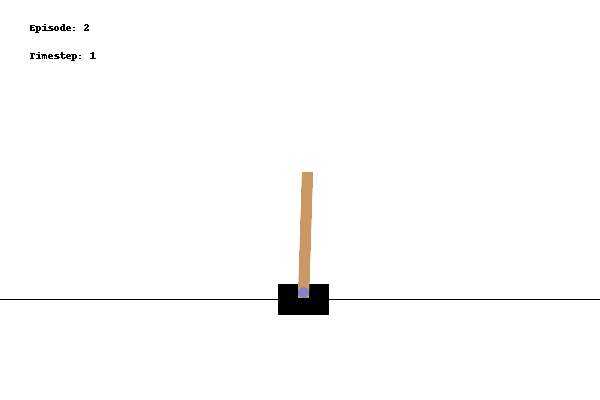

In [22]:
from IPython import display
display.Image(open('/content/drive/MyDrive/Gif/A3C_agent.gif','rb').read())